# Загрузка библиотек

In [1]:
!pip install catboost

     |████████████████████████████████| 66.3MB 63kB/s 


In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from tqdm.notebook import tqdm
 
from google.colab import files
 
from sklearn import metrics
from sklearn.model_selection import train_test_split
import catboost as cat
from scipy.signal import savgol_filter
from sklearn.model_selection import KFold

In [4]:
data_dir = '/content/drive/My Drive/StrawBerry/'

In [5]:
!ls '/content/drive/My Drive/StrawBerry/'

best_data.csv	    greehouse_schema.png  recomend.csv	    strawberry.ipynb
data_orig.csv	    harvest_yields.csv	  recomend_raw.csv
data_recommend.csv  readme.txt		  sensor_data.csv


# Загрузка данных

In [6]:
sensor = pd.read_csv(data_dir + '/sensor_data.csv', index_col=0)
harvest = pd.read_csv(data_dir + '/harvest_yields.csv', index_col=0)

In [7]:
sensor.date = pd.to_datetime(sensor.date)
sensor = sensor.sort_values('date').reset_index(drop=True)

In [8]:
sensor.columns = ['date', 'temperature', 
                   'humidity_1', 'light_1', 'acid_1',
                   'humidity_2', 'light_2', 'acid_2',
                   'humidity_3', 'light_3', 'acid_3',
                   'humidity_4', 'light_4', 'acid_4',
                   'humidity_5', 'light_5', 'acid_5']

In [9]:
def get_date(col):
    d = []
    for i in range(len(col)):
        d.append(col[i].date()) 
    return d

sensor['date_only'] = get_date(sensor['date'])

# Анализ данных

Сезоны и урожайность

In [10]:
seasons = [['2052-01-01', '2052-03-31']]
y = [7.1]
for i in range(1, harvest.shape[0]):
    seasons.append([harvest.index[i-1], harvest.index[i]])
    y.append(harvest['Урожай'][i])
print(len(seasons), len(y))

12 12


**Исследование взаимосвязей между параметрами**

In [11]:
def plot_temp(start, end, tepl):
    fig, ax = plt.subplots(figsize=(25, 6))
    x_data = sensor.loc[(sensor.date >= start)&(sensor.date < end), 'date']
    temp_data = sensor.loc[(sensor.date >= start)&(sensor.date < end), 'temperature']
    ax.plot(x_data, temp_data, color='#D96296', linewidth=3)
    sav_data = savgol_filter(temp_data, 31, 1)
    ax.plot(x_data, sav_data, color='#62D966', linewidth=3)
    ax.legend(['simple', 'savgol'])
    ax.set(title='Temperature')
    ax.fill_between(x_data, (sav_data-4), (sav_data+4), color='#62D966', alpha=.3)
    ax.grid()
    ax.set(xlabel="Day",
           ylabel="Temperature")
    plt.show()

def plot_hum(start, end, tepl):
    fig, ax = plt.subplots(figsize=(25, 6))
    x_data = sensor.loc[(sensor.date >= start)&(sensor.date < end), 'date']
    temp_data = sensor.loc[(sensor.date >= start)&(sensor.date < end), 'humidity_{}'.format(tepl)]
    ax.plot(x_data, temp_data, color='#D96296', linewidth=3)
    sav_data = savgol_filter(temp_data, 31, 1)
    ax.plot(x_data, sav_data, color='#62D966', linewidth=3)
    ax.legend(['simple', 'savgol'])
    ax.set(title='Humidity')
    ax.fill_between(x_data, (sav_data-25), (sav_data+25), color='#62D966', alpha=.3)
    ax.grid()
    ax.set(xlabel="Day",
           ylabel="Humidity")
    plt.show()

def plot_light(start, end, tepl):
    fig, ax = plt.subplots(figsize=(25, 6))
    x_data = sensor.loc[(sensor.date >= start)&(sensor.date < end), 'date']
    temp_data = sensor.loc[(sensor.date >= start)&(sensor.date < end), 'light_{}'.format(tepl)]
    ax.plot(x_data, temp_data, color='#D96296', linewidth=3)
    sav_data = savgol_filter(temp_data, 31, 1)
    ax.plot(x_data, sav_data, color='#62D966', linewidth=3)
    ax.legend(['simple', 'savgol'])
    ax.set(title='Light')
    ax.fill_between(x_data, (sav_data-45), (sav_data+45), color='#62D966', alpha=.3)
    ax.grid()
    ax.set(xlabel="Day",
           ylabel="Light")
    plt.show()

def plot_acid(start, end, tepl):
    fig, ax = plt.subplots(figsize=(25, 6))
    x_data = sensor.loc[(sensor.date >= start)&(sensor.date < end), 'date']
    temp_data = sensor.loc[(sensor.date >= start)&(sensor.date < end), 'acid_{}'.format(tepl)]
    ax.plot(x_data, temp_data, color='#D96296', linewidth=3)
    sav_data = savgol_filter(temp_data, 31, 1)
    ax.plot(x_data, sav_data, color='#62D966', linewidth=3)
    ax.legend(['simple', 'savgol'])
    ax.set(title='Acid')
    ax.fill_between(x_data, (sav_data-0.5), (sav_data+0.5), color='#62D966', alpha=.3)
    ax.grid()
    ax.set(xlabel="Day",
           ylabel="Acid")
    plt.show()

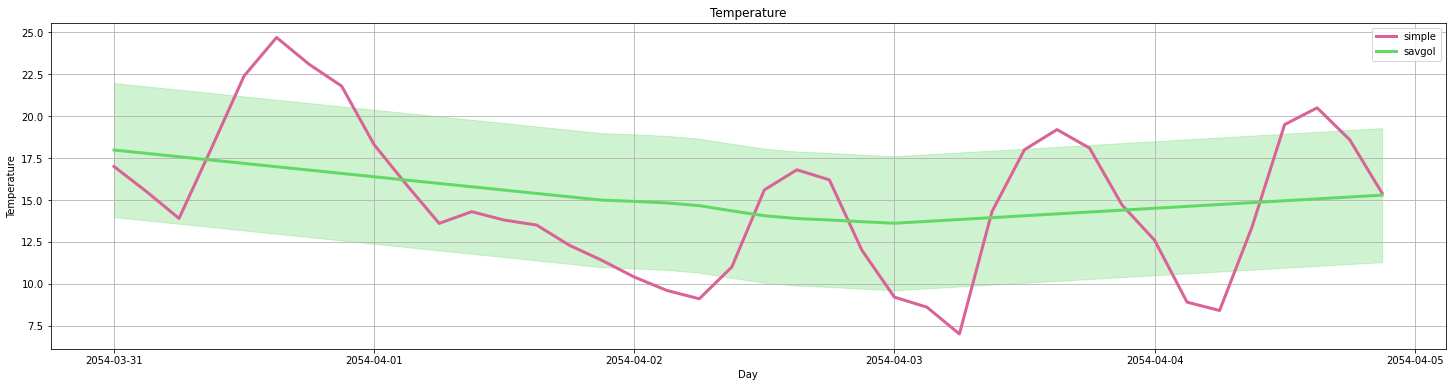

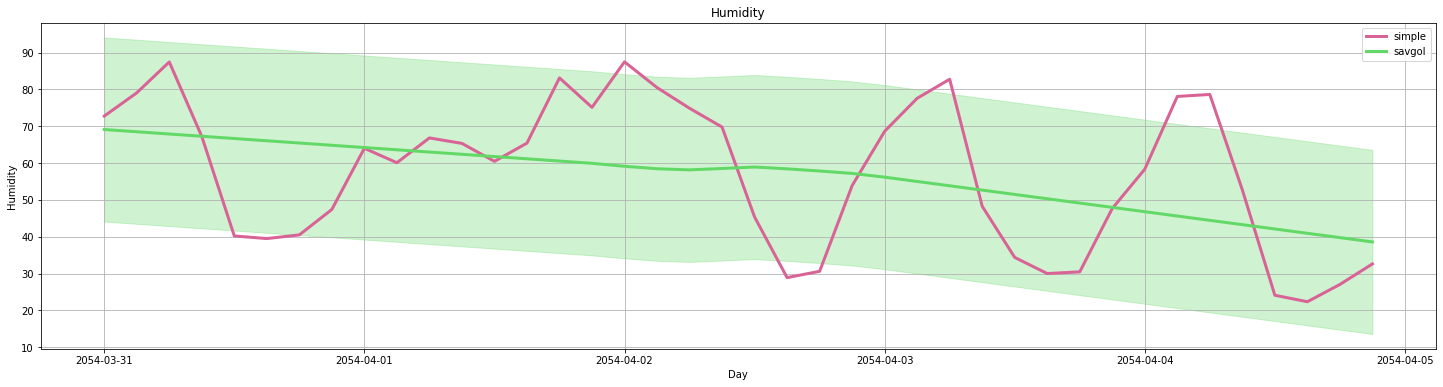

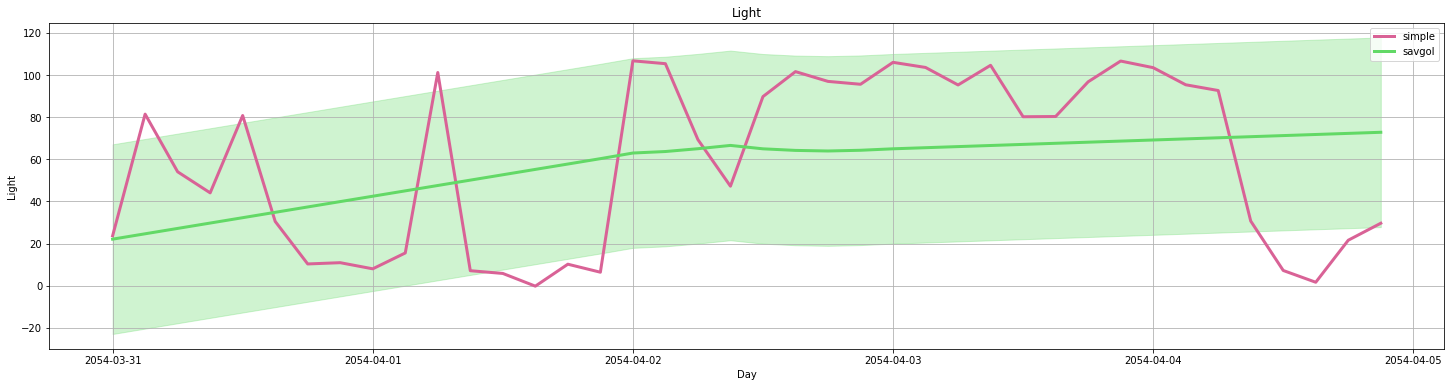

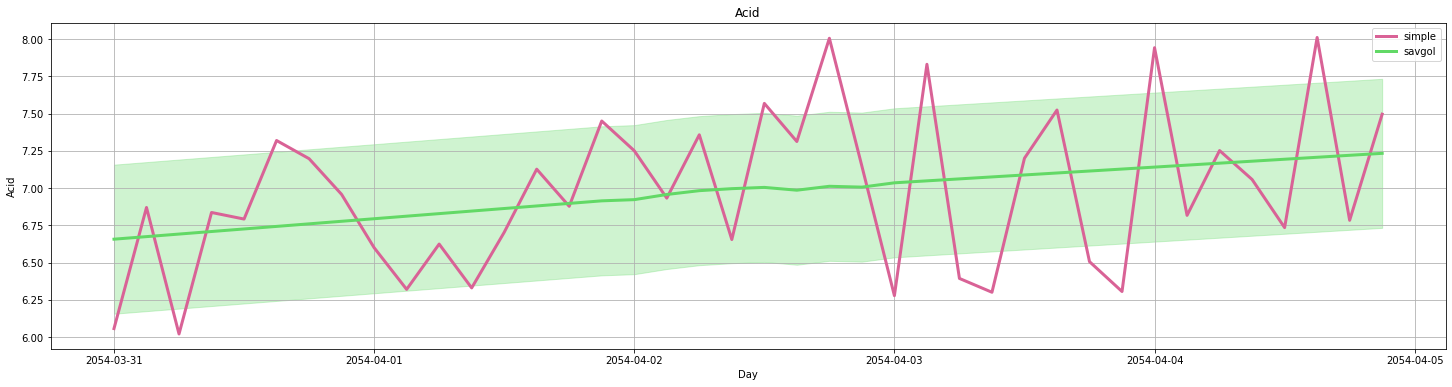

In [12]:
plot_temp('2054-03-31', '2054-04-5', 1)
plot_hum('2054-03-31', '2054-04-5', 1)
plot_light('2054-03-31', '2054-04-5', 1)
plot_acid('2054-03-31', '2054-04-5', 1)

**Можно заметить частые и сильные скачки значений. Их объясняет время суток.**

**Буду учитывать дневные максимальные температуры, так как они делают основной вклад в урожайность.** Ночные температуры при этом не должны отклоняться более чем на 8 градусов.

**Относительная важность будет браться средним значением в сутки.**

**Освещенность будет учитываться суммарным значением за день.** Так как для активного роста клубника должна получать свет около 14 часов. Но нам даны абстрактные данные об освещенности, поэтому будем учитывать именно суммарное значение.

**Кислотность будет учитываться как среднее значение за сутки.**

In [13]:
def plot_case(case):
    
    fig, ax = plt.subplots(figsize=(25, 6))

    print(y[case])

    start, end = seasons[case][0], seasons[case][1]

    x_data = sensor.loc[(sensor.date >= start)&(sensor.date < end)].groupby('date_only').max().index

    max_data = sensor.loc[(sensor.date >= start)&(sensor.date < end)].groupby('date_only').max()['temperature']
    ax.plot(x_data, max_data, color='blue', linewidth=3)

    min_data = sensor.loc[(sensor.date >= start)&(sensor.date < end)].groupby('date_only').min()['temperature']
    ax.plot(x_data, min_data, color='red', linewidth=3)

    sav_data = savgol_filter(max_data, 15, 2)
    ax.plot(x_data, sav_data, color='yellow', linewidth=3)

    ax.legend(['simple', 'filter'])
    ax.set(title='Temperature')
    ax.fill_between(x_data, (max_data-8), (max_data), color='blue', alpha=.3)
    ax.grid()
    ax.set(xlabel="Day",
           ylabel="Temperature")
    plt.show()

7.1


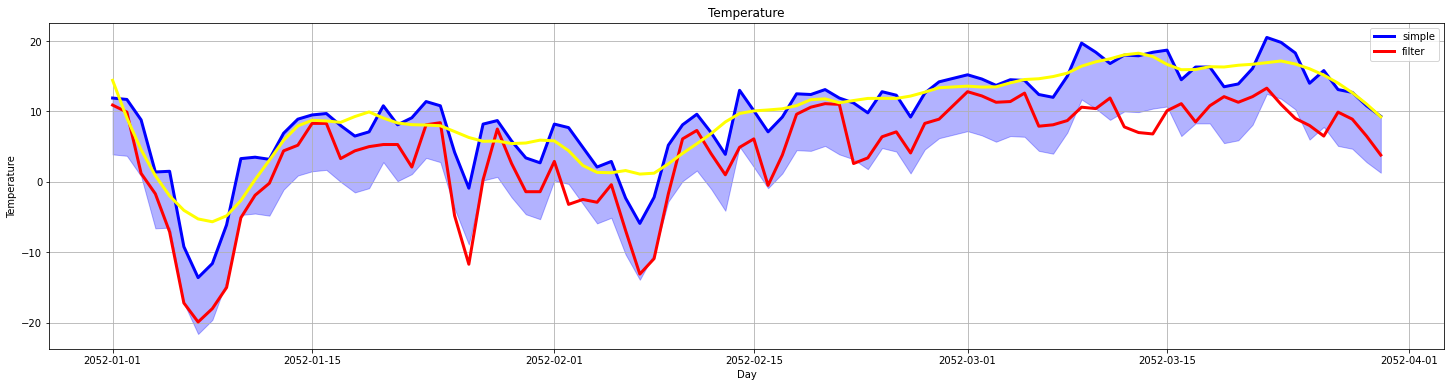

12.0


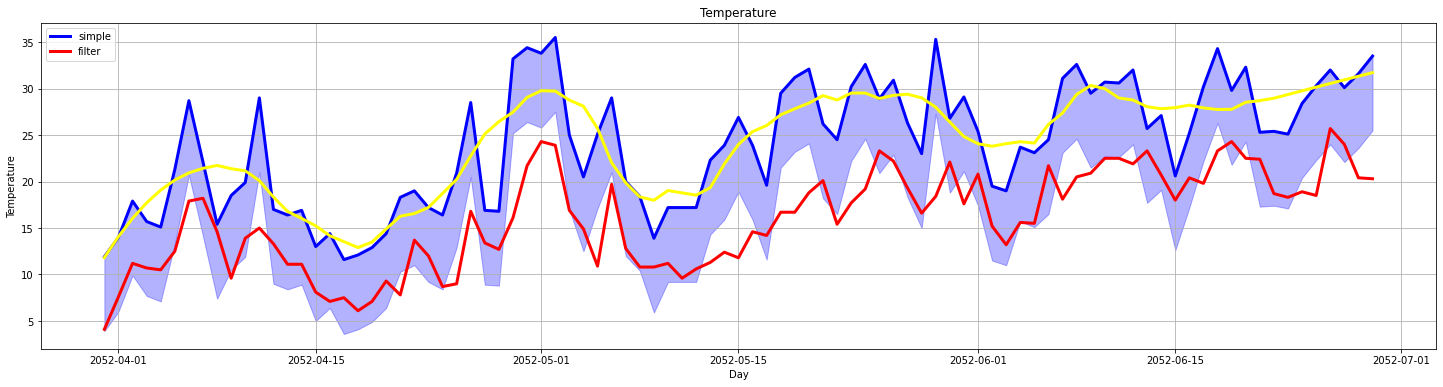

16.7


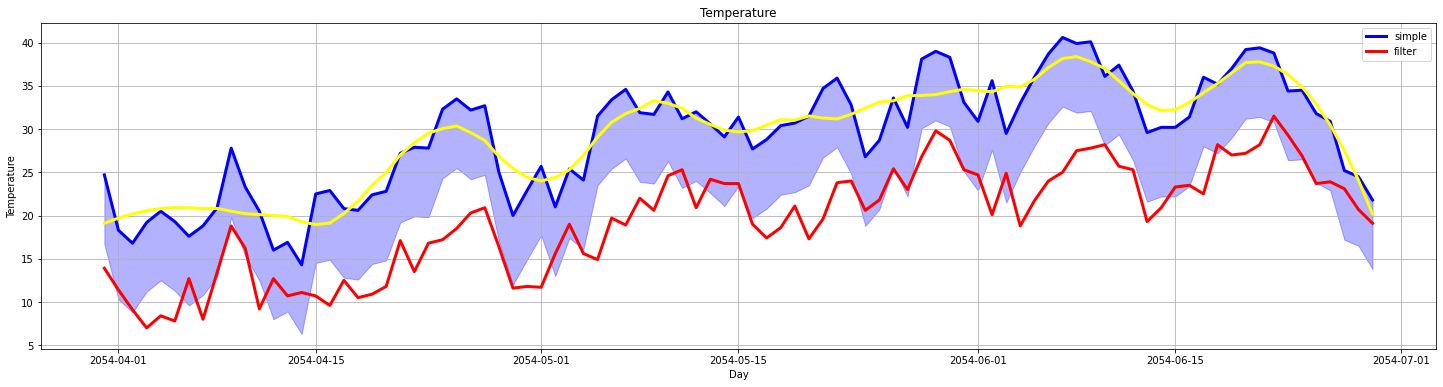

In [14]:
plot_case(0)
plot_case(1)
plot_case(9)

**Мы можем заметить, что в некоторых случаях температура падали ниже 10 градусов и урожай снижался соответственно. Предположительно в эти года высаживали новые клубни. Наиболее эффективный урожай получался, когда температура держалась выше 20-25 градусов.**

In [15]:
start, end = seasons[9][0], seasons[9][1]

In [16]:
data = pd.DataFrame()
data['harvest'] = harvest['Урожай'].reset_index(drop=True)
data['temperature_25'] = 0
data['temperature_50'] = 0
data['temperature_75'] = 0
data['humidity_mean'] = 0
data['light_sum'] = 0
data['acid_mean'] = 0

In [17]:
i = 0
for season in seasons:
    data['temperature_50'].iloc[i] = sensor.loc[(sensor.date >= season[0])&(sensor.date < season[1])].temperature.mean()
    data['temperature_25'].iloc[i] = sensor.loc[(sensor.date >= season[0])&(sensor.date < season[1])].temperature.quantile(0.25)
    data['temperature_75'].iloc[i] = sensor.loc[(sensor.date >= season[0])&(sensor.date < season[1])].temperature.quantile(0.75)
    for j in range(1, 6):
        data['humidity_mean'].iloc[i] += sensor.loc[(sensor.date >= season[0])&(sensor.date < season[1])]['humidity_{}'.format(j)].mean()
        data['light_sum'].iloc[i] += sensor.loc[(sensor.date >= season[0])&(sensor.date < season[1])]['light_{}'.format(j)].sum()
        data['acid_mean'].iloc[i] += sensor.loc[(sensor.date >= season[0])&(sensor.date < season[1])]['acid_{}'.format(j)].mean()
    data['humidity_mean'].iloc[i] /= 5
    data['light_sum'].iloc[i] /= 5
    data['acid_mean'].iloc[i] /= 5
    i += 1

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [18]:
data.sort_values('harvest', ascending=False)

,harvest,temperature_25,temperature_50,temperature_75,humidity_mean,light_sum,acid_mean
9,16.7,19.300,24.635577,30.000,55.378599,30418.966138,6.978408
5,14.0,19.100,23.537225,28.600,58.467254,28145.674487,7.044203
11,13.7,10.250,13.956735,18.250,82.626781,11332.913481,7.056967
6,12.3,24.975,28.519565,32.200,67.874830,31985.330730,6.962156
1,12.0,14.700,19.995467,25.000,65.559301,20983.828981,6.996692
2,10.0,22.800,26.757609,30.525,73.016364,26028.494700,6.957574
10,9.4,21.875,25.212228,28.800,73.488798,25184.654099,7.011320
4,7.5,0.800,3.943750,7.300,73.796323,19174.088816,7.099417
0,7.1,3.200,6.682022,11.700,79.204508,16604.912346,6.977377
3,6.2,9.300,11.782609,14.500,85.035860,7114.841912,6.976433


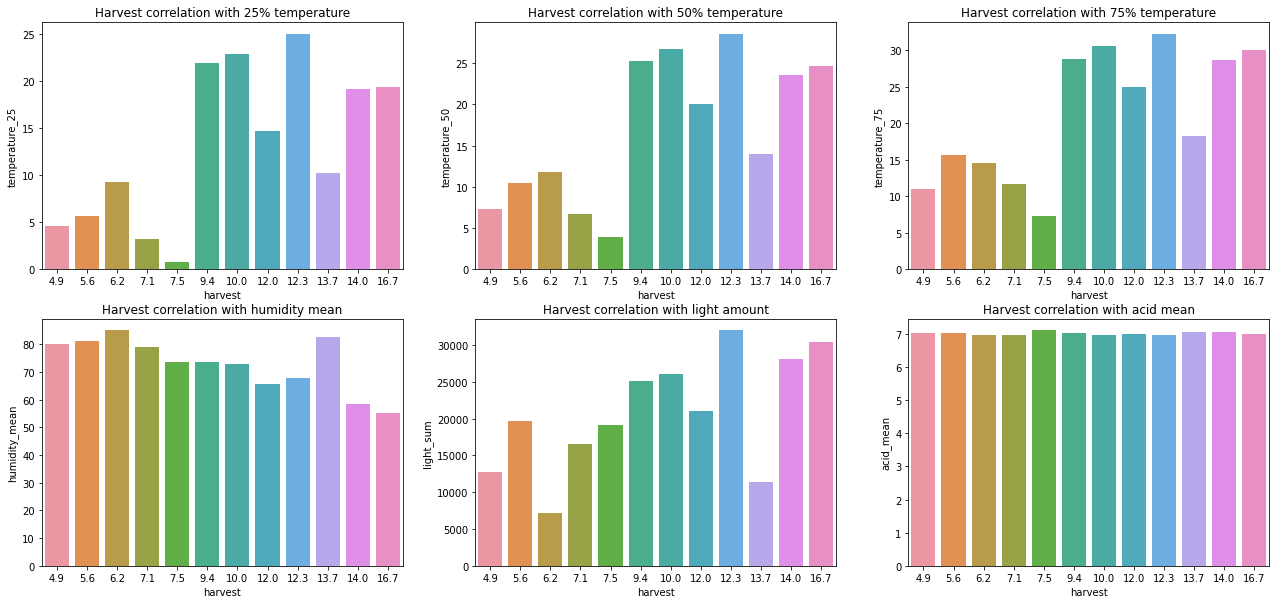

In [19]:
fig, ax = plt.subplots(2, 3, figsize=(22, 10))
sns.barplot(x=data['harvest'], y=data['temperature_25'], ax=ax[0][0])
ax[0][0].set(title='Harvest correlation with 25% temperature')
sns.barplot(x=data['harvest'], y=data['temperature_50'], ax=ax[0][1])
ax[0][1].set(title='Harvest correlation with 50% temperature')
sns.barplot(x=data['harvest'], y=data['temperature_75'], ax=ax[0][2])
ax[0][2].set(title='Harvest correlation with 75% temperature')
sns.barplot(x=data['harvest'], y=data['humidity_mean'], ax=ax[1][0])
ax[1][0].set(title='Harvest correlation with humidity mean')
sns.barplot(x=data['harvest'], y=data['light_sum'], ax=ax[1][1])
ax[1][1].set(title='Harvest correlation with light amount')
sns.barplot(x=data['harvest'], y=data['acid_mean'], ax=ax[1][2])
ax[1][2].set(title='Harvest correlation with acid mean')
fig.show()

Наибольший урожай достигался, если температура в большинстве случаев находилась в пределах **от 19 до 30 градусов**, а средняя температура колебалась **от 23 до 25 градусов**. Эти данные соответсвуют общепринятым температурам для выращивания клубники.

Также можно заметить, что наибольшая урожайность достигалась при **уменьшенной увлажненности почвы**. Это опять же соотвествует практикам выращивания клубники, когда при созревании уменяьшается полив, для получения более качественного урожая.

Клубника светолюбивое растение. Неудивительно, что высокая урожайность достигалась в купе с **большим количество света**.

**Средняя кислотность** почвы во всех случаях находилась **в районе 7**.

**Выделение полного цикла роста клубники.**

5.6


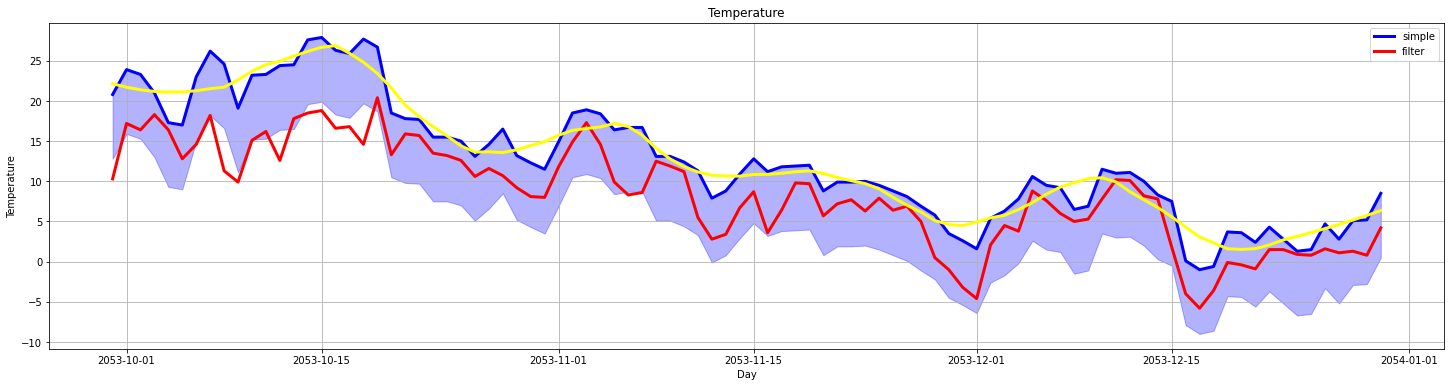

4.9


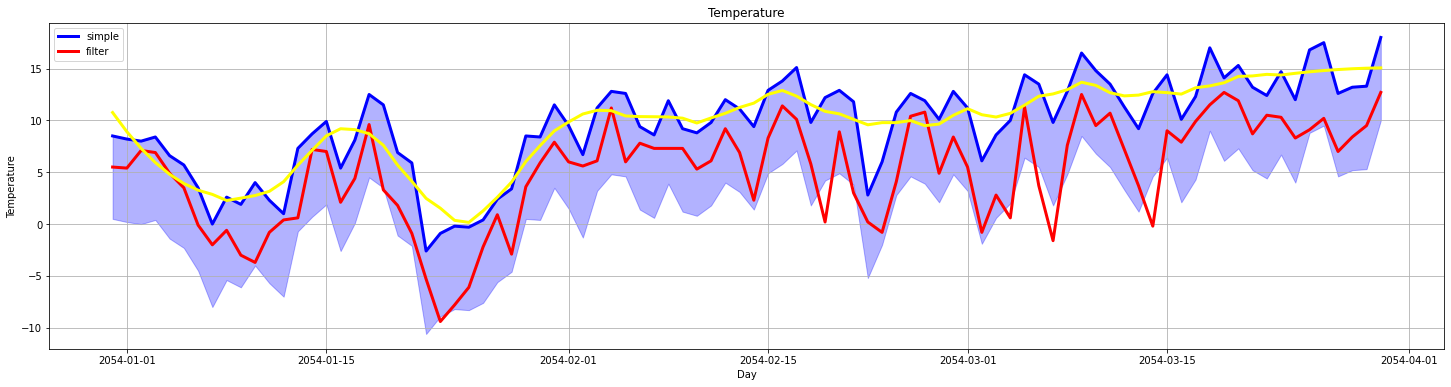

16.7


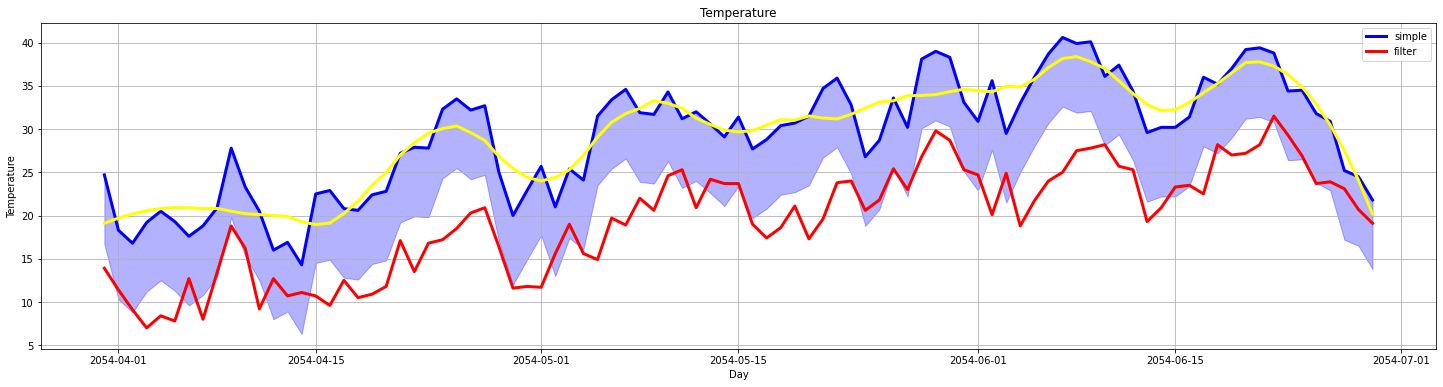

9.4


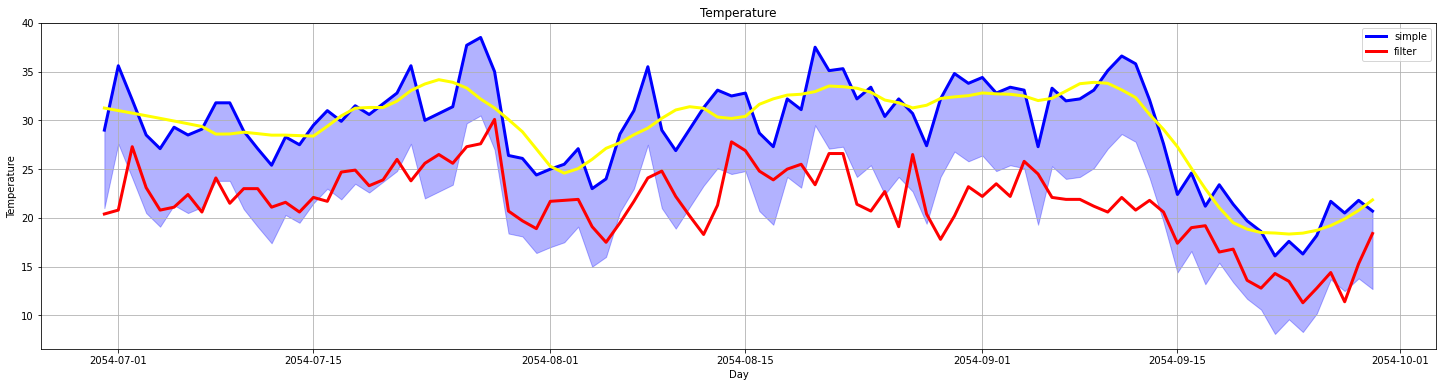

13.7


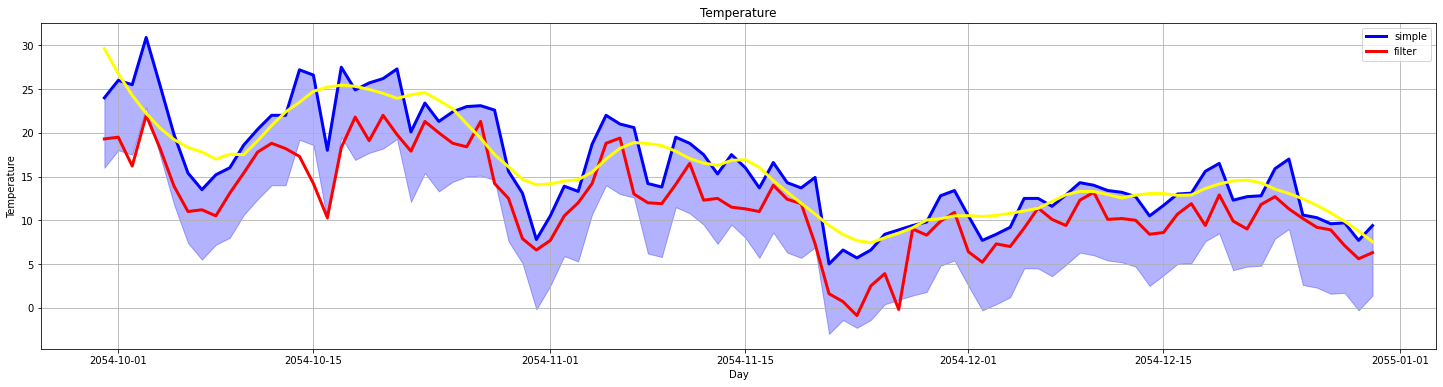

In [20]:
plot_case(7)
plot_case(8)
plot_case(9)
plot_case(10)
plot_case(11)

Можно увидеть как после 2053-10-15 температура начинает падать. Логично, что при температуре ниже 10 градусов клубника расти не будет.

2054-02-01 была высажена клубника и в дальнейшем температура будет расти.

Период с 2054-04-01 по 2054-06-30 окажется самсым урожайным. Урожай будет собираться вплоть до 2054-11-15, когда температура начала падать до 10 градусов.

In [21]:
def all_loop_plot(start, end):

    fig, ax = plt.subplots(figsize=(25, 6))

    x_data = sensor.loc[(sensor.date >= start)&(sensor.date < end)].groupby('date_only').max().index

    max_data = sensor.loc[(sensor.date >= start)&(sensor.date < end)].groupby('date_only').max()['temperature']
    ax.plot(x_data, max_data, color='blue', linewidth=3)

    min_data = sensor.loc[(sensor.date >= start)&(sensor.date < end)].groupby('date_only').min()['temperature']
    ax.plot(x_data, min_data, color='red', linewidth=3)

    sav_data = savgol_filter(max_data, 31, 2)
    ax.plot(x_data, sav_data, color='yellow', linewidth=3)

    ax.plot(x_data, [10 for _ in range(len(x_data))], color='black', linewidth=3)

    ax.legend(['max', 'min', 'filter'])
    ax.set(title='Temperature')
    ax.fill_between(x_data, (max_data-8), (max_data), color='blue', alpha=.2)
    ax.grid()
    ax.set(xlabel="Day",
        ylabel="Temperature")
    plt.show()

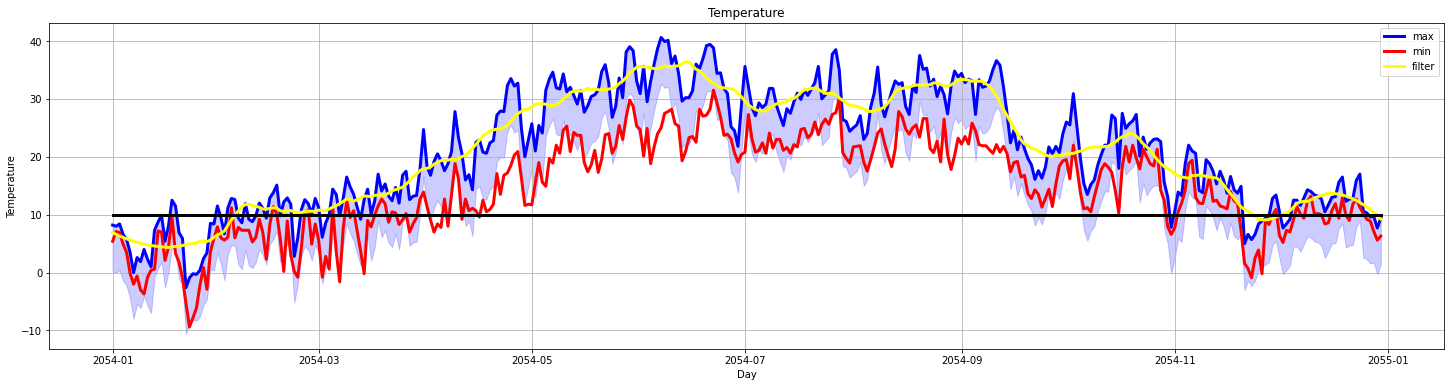

Суммарный урожай равен 44.7


In [22]:
all_loop_plot('2054-01-01', '2054-12-31')
print('\033[1m' + 'Суммарный урожай равен {}'.format(y[8] + y[9] + y[10] + y[11]) + '\033[0m')

Выявлен полный цикл одного посева, который длится год.

Такие же циклы будут и для 2052, 2053 годов.

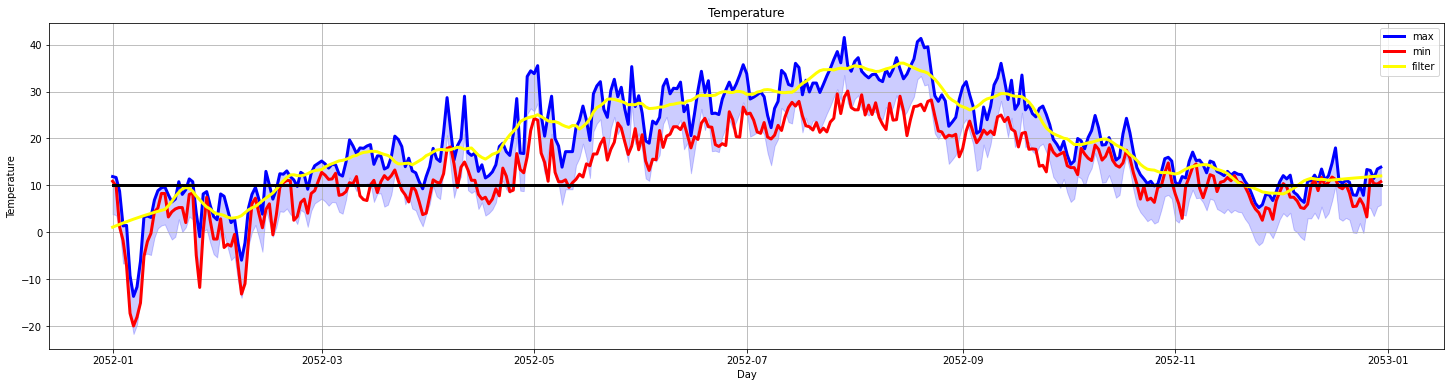

Суммарный урожай равен 35.3


In [23]:
all_loop_plot('2052-01-01', '2052-12-31')
print('\033[1m' + 'Суммарный урожай равен {}'.format(round(y[0] + y[1] + y[2] + y[3], 1)) + '\033[0m')

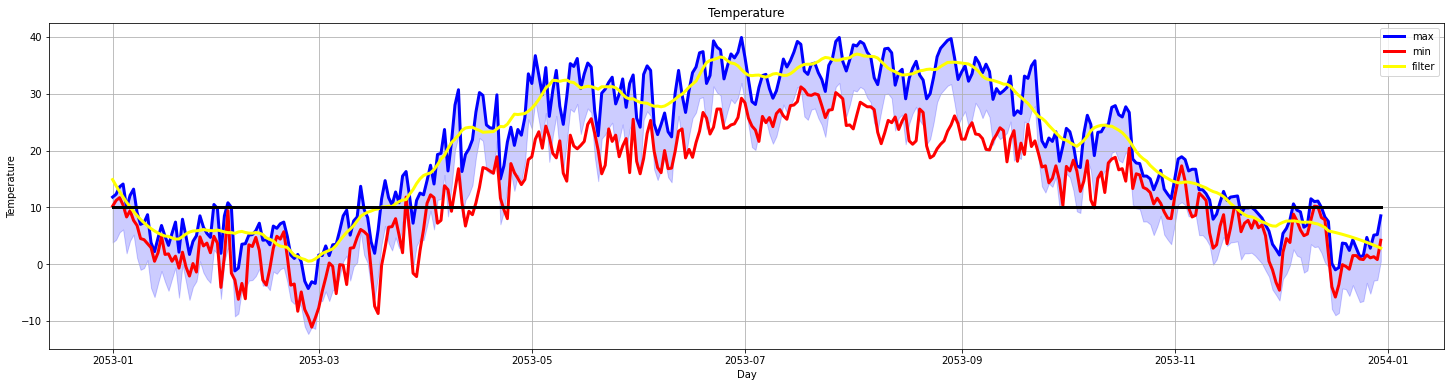

Суммарный урожай равен 39.4


In [24]:
all_loop_plot('2053-01-01', '2053-12-31')
print('\033[1m' + 'Суммарный урожай равен {}'.format(round(y[4] + y[5] + y[6] + y[7], 1)) + '\033[0m')

# Создание предсказательной модели на основе самого урожайного цикла за 2054 год.

**Сборка тренировочного датасета.**

Данные с разных теплиц будут агрегироваться в единые, так как оценка урожайности ведется по всему комплексу.

In [25]:
data_raw = pd.DataFrame()
data_raw_test = pd.DataFrame()
sensor_temp = sensor[(sensor.date >= '2054-01-01')&(sensor.date < '2055-01-01')]
sensor_temp_test = sensor[(sensor.date >= '2053-01-01')&(sensor.date < '2054-01-01')]

In [26]:
data_raw['temperature'] = sensor_temp.groupby('date_only').temperature.max()
data_raw_test['temperature'] = sensor_temp_test.groupby('date_only').temperature.max()

In [27]:
data_raw['humidity_mean'] = 0
data_raw['light_sum'] = 0
data_raw['acid_mean'] = 0

for j in range(1, 6):
    data_raw['humidity_mean'] += sensor_temp.groupby('date_only')['humidity_{}'.format(j)].mean()
    data_raw['light_sum'] += sensor_temp.groupby('date_only')['light_{}'.format(j)].sum()
    data_raw['acid_mean'] += sensor_temp.groupby('date_only')['acid_{}'.format(j)].mean()

data_raw['humidity_mean'] /= 5
data_raw['light_sum'] /= 5
data_raw['acid_mean'] /= 5

data_raw['acid_mean'] = data_raw['acid_mean'].fillna(data_raw.acid_mean.mean())
data_raw['humidity_mean'] = data_raw['humidity_mean'].fillna(data_raw.humidity_mean.mean())

In [28]:
data_raw_test['humidity_mean'] = 0
data_raw_test['light_sum'] = 0
data_raw_test['acid_mean'] = 0

for j in range(1, 6):
    data_raw_test['humidity_mean'] += sensor_temp_test.groupby('date_only')['humidity_{}'.format(j)].mean()
    data_raw_test['light_sum'] += sensor_temp_test.groupby('date_only')['light_{}'.format(j)].sum()
    data_raw_test['acid_mean'] += sensor_temp_test.groupby('date_only')['acid_{}'.format(j)].mean()

data_raw_test['humidity_mean'] /= 5
data_raw_test['light_sum'] /= 5
data_raw_test['acid_mean'] /= 5

data_raw_test['acid_mean'] = data_raw_test['acid_mean'].fillna(data_raw_test.acid_mean.mean())
data_raw_test['humidity_mean'] = data_raw_test['humidity_mean'].fillna(data_raw_test.humidity_mean.mean())

**Графики всех параметров за 2054 год.**

In [29]:
def param_plot(X_raw, param, border=0, between=0, ticks=5, max=40, min=-10):

    fig, ax = plt.subplots(figsize=(25, 6))

    x_data = X_raw.index

    data = X_raw[param]
    ax.plot(x_data, data, color='blue', linewidth=3)

    sav_data = savgol_filter(data, 31, 2)
    ax.plot(x_data, sav_data, color='yellow', linewidth=3)

    ax.plot(x_data, [border for _ in range(len(x_data))], color='black', linewidth=3)

    ax.legend(['param_data', 'filter_param_data'])
    ax.set(title=param)
    ax.fill_between(x_data, (sav_data-between), (sav_data+between), color='blue', alpha=.2)
    
    ax.grid()
    major_ticks = np.arange(min, max, ticks)
    ax.set_yticks(major_ticks)
    ax.set(xlabel='day',
           ylabel=param)
    plt.show()

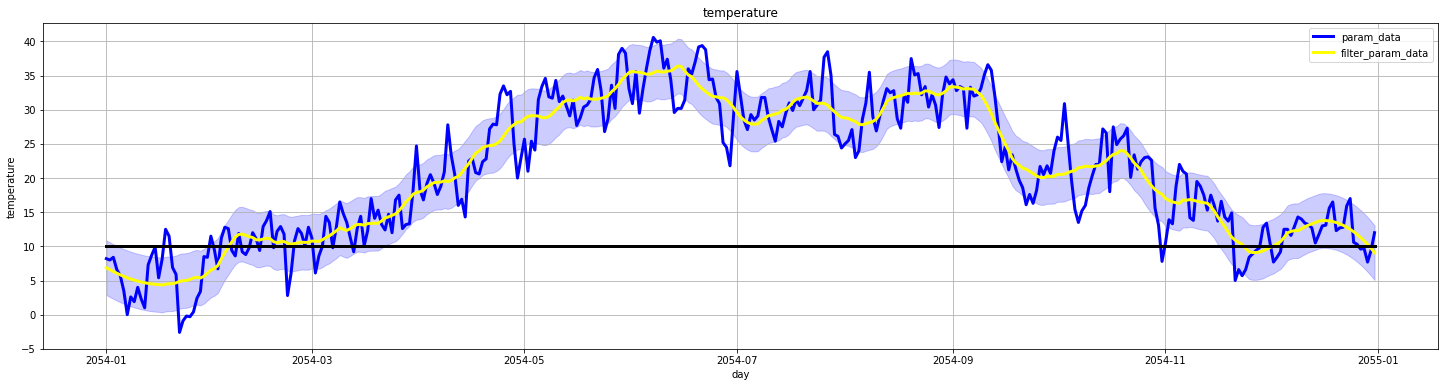

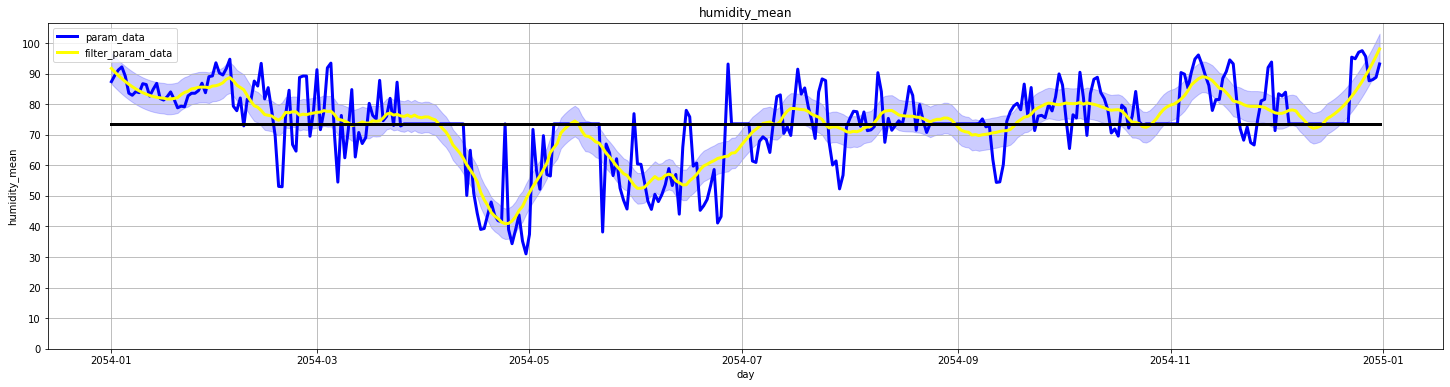

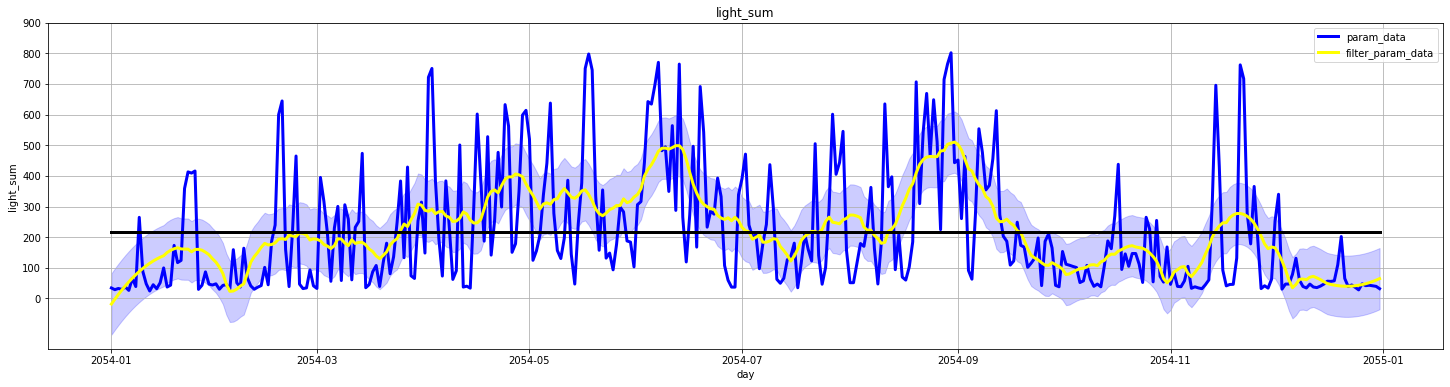

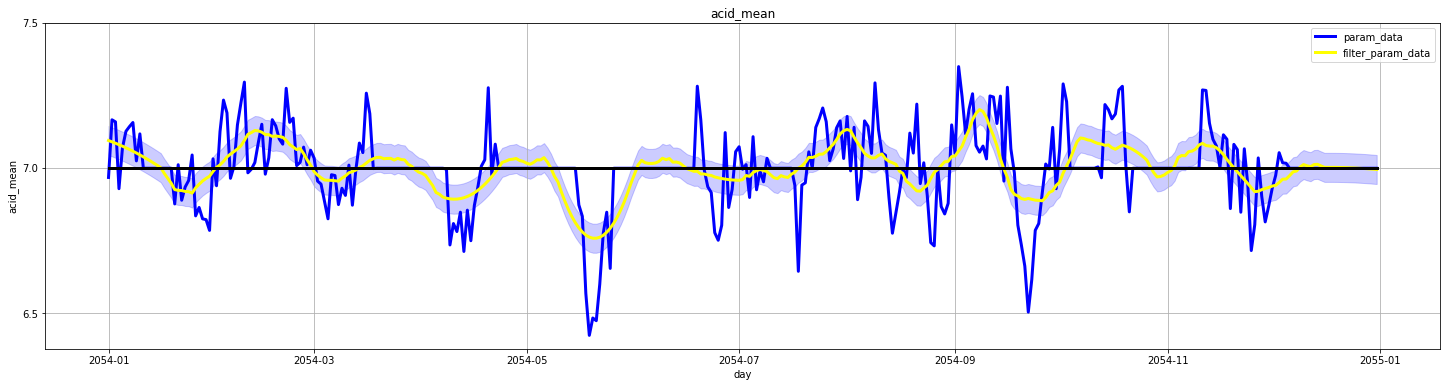

In [30]:
param_plot(data_raw, 'temperature', 
           border=10, between=4, ticks=5, max=45, min=-5)

param_plot(data_raw, 'humidity_mean', 
           border=data_raw['humidity_mean'].mean(), between=5, ticks=10, max=110, min=0)

param_plot(data_raw, 'light_sum', 
           border=data_raw['light_sum'].mean(), between=100, ticks=100, max=1000, min=0)

param_plot(data_raw, 'acid_mean', 
           border=data_raw['acid_mean'].mean(), between=0.05, ticks=0.5, max=8, min=6.5)

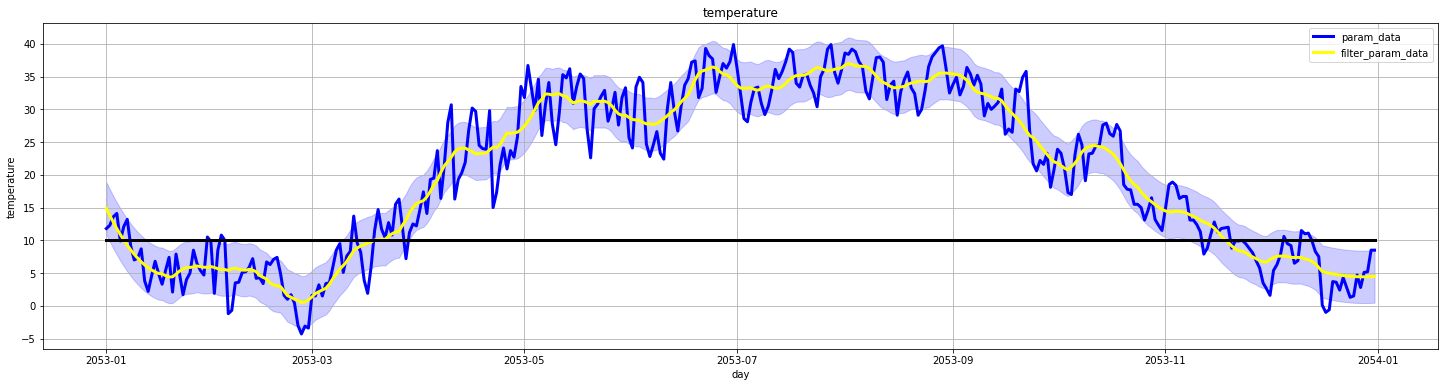

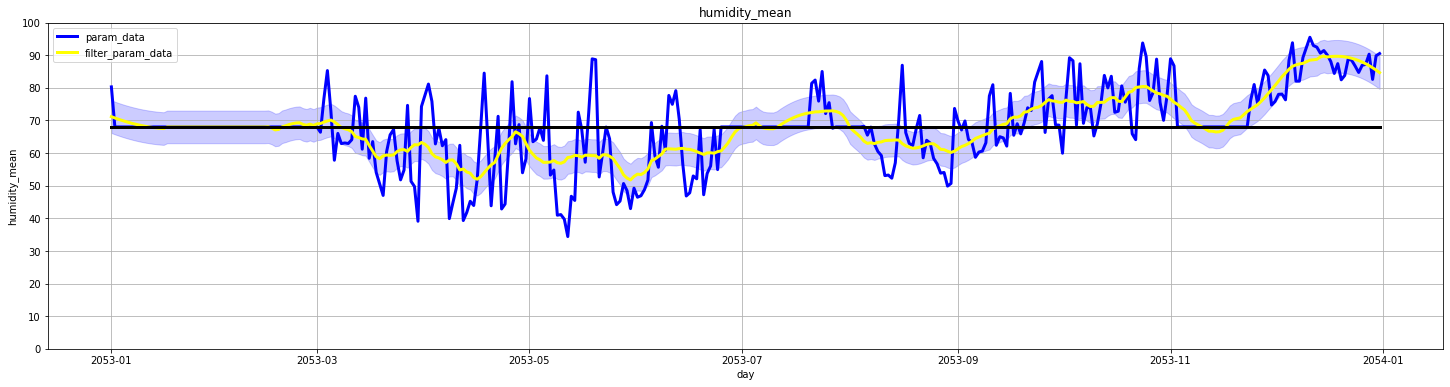

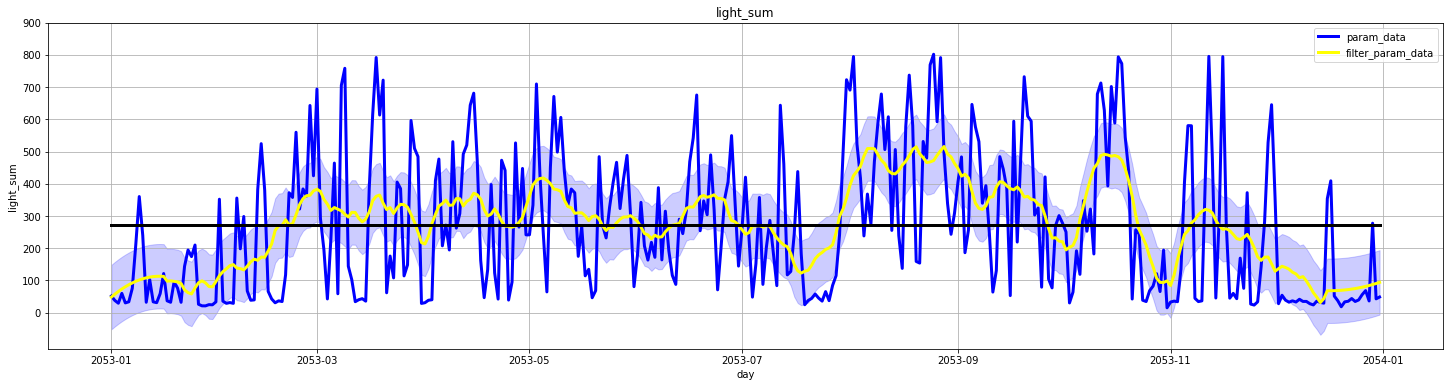

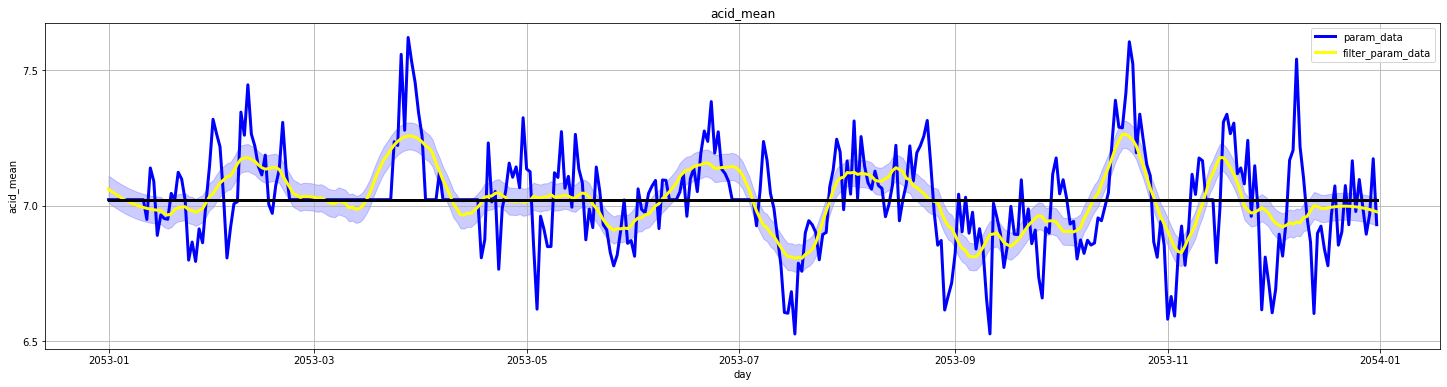

In [31]:
param_plot(data_raw_test, 'temperature', 
           border=10, between=4, ticks=5, max=45, min=-5)

param_plot(data_raw_test, 'humidity_mean', 
           border=data_raw_test['humidity_mean'].mean(), between=5, ticks=10, max=110, min=0)

param_plot(data_raw_test, 'light_sum', 
           border=data_raw_test['light_sum'].mean(), between=100, ticks=100, max=1000, min=0)

param_plot(data_raw_test, 'acid_mean', 
           border=data_raw_test['acid_mean'].mean(), between=0.05, ticks=0.5, max=8, min=6.5)

Какие **выводы** можно сделать, исходя из графиков параметров теплицы.



> 1. Стоит стабилизировать температуру, чтобы избежать скачков от 40 до 25 градусов, так как это плохо влияет на урожай. Температура не должна превышать 35 градусов (это же показывает мировой опыт выращивания клубники). После высаживания клубники при 10 градусах, температура должна только расти. Также надо помнить о том, что ночная температура (минимальная за сутки) не должна отличаться от максимальной более чем на 8 градусов.



> 2. Влажность также стоит стабилизировать, чтобы избежать резких изменений.



> 3. О световом режиме сделать выводы достаточно сложно ввиду абстрактности данных. Нам известно, что наиболее эффективно, когда световой день составляет около 14 часов в сутки. В данных же мы видим резкие скачки значений суммарного количества света. Наверное стоит опять же стабилизировать количество света, которое клубника получает в сутки.



> 4. Средний уровень кислотность примерно равен 7. В течении года мы видим отклонения. Здесь стоит дать совет, чтобы эти отклонения находились в пределах от 6.5 до 7.5.










> Также нельзя не заметить, что данные содержат пропущенные значения, что может означать неполадки датчиков. Об этих случаях нужно будет сообщать фермеру.



Для обучения модели будут использованы сглаженные функции. И данные будут отсечены до полезных участков от 2054-02-05 до 2054-11-01, так как процесс роста приходится только на этот участок.

In [32]:
X_raw = pd.DataFrame()

X_raw['temperature'] = savgol_filter(data_raw[(data_raw.index > pd.to_datetime('2054-02-05'))&
                                                (data_raw.index < pd.to_datetime('2054-11-01'))]['temperature'], 31, 2)

X_raw['humidity_mean'] = savgol_filter(data_raw[(data_raw.index > pd.to_datetime('2054-02-05'))&
                                                  (data_raw.index < pd.to_datetime('2054-11-01'))]['humidity_mean'], 31, 2)

X_raw['light_sum'] = savgol_filter(data_raw[(data_raw.index > pd.to_datetime('2054-02-05'))&
                                              (data_raw.index < pd.to_datetime('2054-11-01'))]['light_sum'], 31, 2)

X_raw['acid_mean'] = savgol_filter(data_raw[(data_raw.index > pd.to_datetime('2054-02-05'))&
                                              (data_raw.index < pd.to_datetime('2054-11-01'))]['acid_mean'], 31, 2)

X_raw.index = data_raw[(data_raw.index > pd.to_datetime('2054-02-05'))&(data_raw.index < pd.to_datetime('2054-11-01'))].index

In [33]:
X_raw_test = pd.DataFrame()

X_raw_test['temperature'] = savgol_filter(data_raw_test[(data_raw_test.index > pd.to_datetime('2053-02-05'))&
                                                (data_raw_test.index < pd.to_datetime('2053-11-01'))]['temperature'], 31, 2)

X_raw_test['humidity_mean'] = savgol_filter(data_raw_test[(data_raw_test.index > pd.to_datetime('2053-02-05'))&
                                                  (data_raw_test.index < pd.to_datetime('2053-11-01'))]['humidity_mean'], 31, 2)

X_raw_test['light_sum'] = savgol_filter(data_raw_test[(data_raw_test.index > pd.to_datetime('2053-02-05'))&
                                              (data_raw_test.index < pd.to_datetime('2053-11-01'))]['light_sum'], 31, 2)

X_raw_test['acid_mean'] = savgol_filter(data_raw_test[(data_raw_test.index > pd.to_datetime('2053-02-05'))&
                                              (data_raw_test.index < pd.to_datetime('2053-11-01'))]['acid_mean'], 31, 2)

X_raw_test.index = data_raw_test[(data_raw_test.index > pd.to_datetime('2053-02-05'))&(data_raw_test.index < pd.to_datetime('2053-11-01'))].index

In [34]:
X = pd.DataFrame()
test_X = pd.DataFrame()

y = X_raw
test_y = X_raw_test

In [35]:
for i in range(1, 61):

    X['temperature_{}'.format(i)] = X_raw.temperature.shift(i)
    X['humidity_{}'.format(i)] = X_raw.humidity_mean.shift(i)
    X['light_{}'.format(i)] = X_raw.light_sum.shift(i)
    X['acid_{}'.format(i)] = X_raw.acid_mean.shift(i)

    test_X['temperature_{}'.format(i)] = X_raw_test.temperature.shift(i)
    test_X['humidity_{}'.format(i)] = X_raw_test.humidity_mean.shift(i)
    test_X['light_{}'.format(i)] = X_raw_test.light_sum.shift(i)
    test_X['acid_{}'.format(i)] = X_raw_test.acid_mean.shift(i)

X['day'] = 0
X['month'] = 0
test_X['day'] = 0
test_X['month'] = 0

for i in range(X.shape[0]):
    X['day'].iloc[i] = X.index[i].day
    X['month'].iloc[i] = X.index[i].month
    test_X['day'].iloc[i] = test_X.index[i].day
    test_X['month'].iloc[i] = test_X.index[i].month

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


**Обучение модели.**

In [36]:
import catboost as cat

In [37]:
model = cat.CatBoostRegressor(
    loss_function='MultiRMSE',
    eval_metric='MultiRMSE',
    iterations=1000,
    verbose=100,
)

In [38]:
model.fit(X, y)

0:	learn: 281.3000259	total: 296ms	remaining: 4m 55s
100:	learn: 33.4611861	total: 19.2s	remaining: 2m 51s
200:	learn: 11.1435396	total: 38.2s	remaining: 2m 31s
300:	learn: 6.7921044	total: 57.1s	remaining: 2m 12s
400:	learn: 4.9427863	total: 1m 16s	remaining: 1m 53s
500:	learn: 3.8790906	total: 1m 35s	remaining: 1m 34s
600:	learn: 3.1588655	total: 1m 54s	remaining: 1m 15s
700:	learn: 2.6140870	total: 2m 13s	remaining: 56.9s
800:	learn: 2.2190045	total: 2m 32s	remaining: 37.8s
900:	learn: 1.9001226	total: 2m 51s	remaining: 18.8s
999:	learn: 1.6402948	total: 3m 10s	remaining: 0us


In [39]:
def predict_plot(y_true, y_pred, param, border=0, between=0, ticks=5, max=40, min=-10):

    fig, ax = plt.subplots(figsize=(25, 6))

    x_data = y_true.index

    data = y_true[param]
    ax.plot(x_data, data, color='red', linewidth=3)

    pred_data = y_pred[param]
    ax.plot(x_data, pred_data, color='green', linewidth=3)

    sav_data = savgol_filter(pred_data, 51, 1)
    ax.plot(x_data, sav_data, color='yellow', linewidth=3)

    ax.plot(x_data, [border for _ in range(len(x_data))], color='black', linewidth=3)

    ax.legend(['true', 'predict', 'recomend'])
    ax.set(title=param)
    ax.fill_between(x_data, (pred_data-between), (pred_data+between), color='green', alpha=.2)
    
    ax.grid()
    major_ticks = np.arange(min, max, ticks)
    ax.set_yticks(major_ticks)
    ax.set(xlabel='day',
           ylabel=param)
    plt.show()

In [40]:
pred_y = pd.DataFrame(model.predict(test_X), columns=test_y.columns)

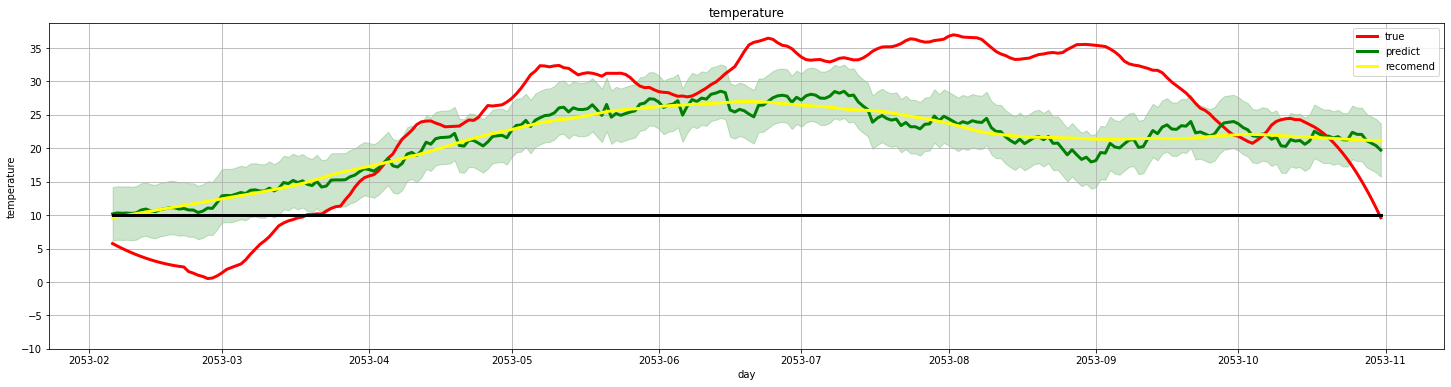

In [41]:
predict_plot(test_y, pred_y, 'temperature',
             10, 4)

Мы получили модель, которая **оптимизирует режим на следующий день**, основываясь на данных до этого дня. Эту модель можно использовать для оптимизации уже растущих растений.

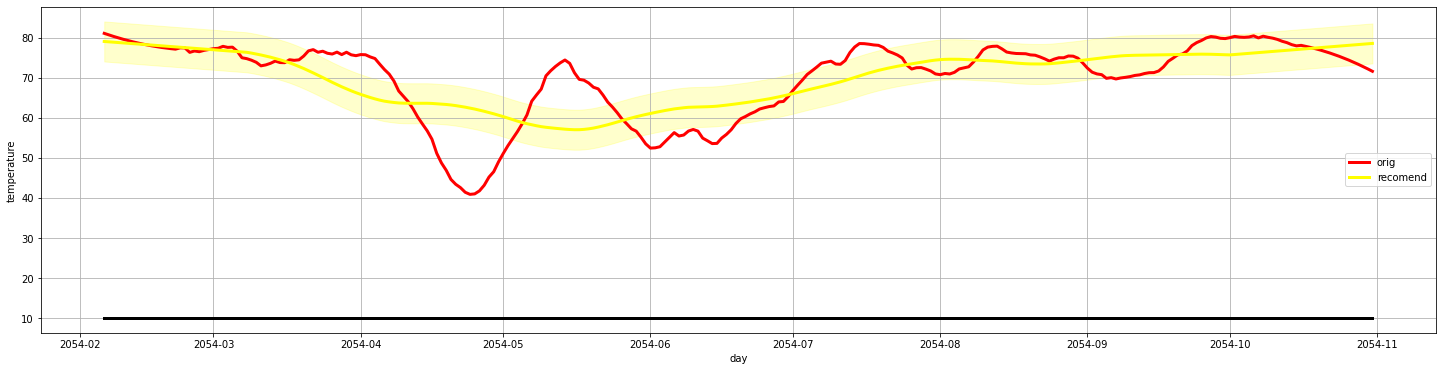

In [42]:
fig, ax = plt.subplots(figsize=(25, 6))

x_data = X_raw['humidity_mean'].index

data = X_raw['humidity_mean']
ax.plot(x_data, data, color='red', linewidth=3)

sav_data = savgol_filter(data, 61, 1)
ax.plot(x_data, sav_data, color='yellow', linewidth=3)

ax.plot(x_data, [10 for _ in range(len(x_data))], color='black', linewidth=3)

ax.legend(['orig', 'recomend'])
ax.fill_between(x_data, (sav_data-5), (sav_data+5), color='yellow', alpha=.2)
ax.grid()
ax.set(xlabel='day',
           ylabel='temperature')
plt.show()

**Экономические выгоды от применения оптимизации**

In [47]:
sav_y = pd.DataFrame() 
for col in pred_y.columns:
    sav_y[col] = savgol_filter(pred_y[col], 51, 1)

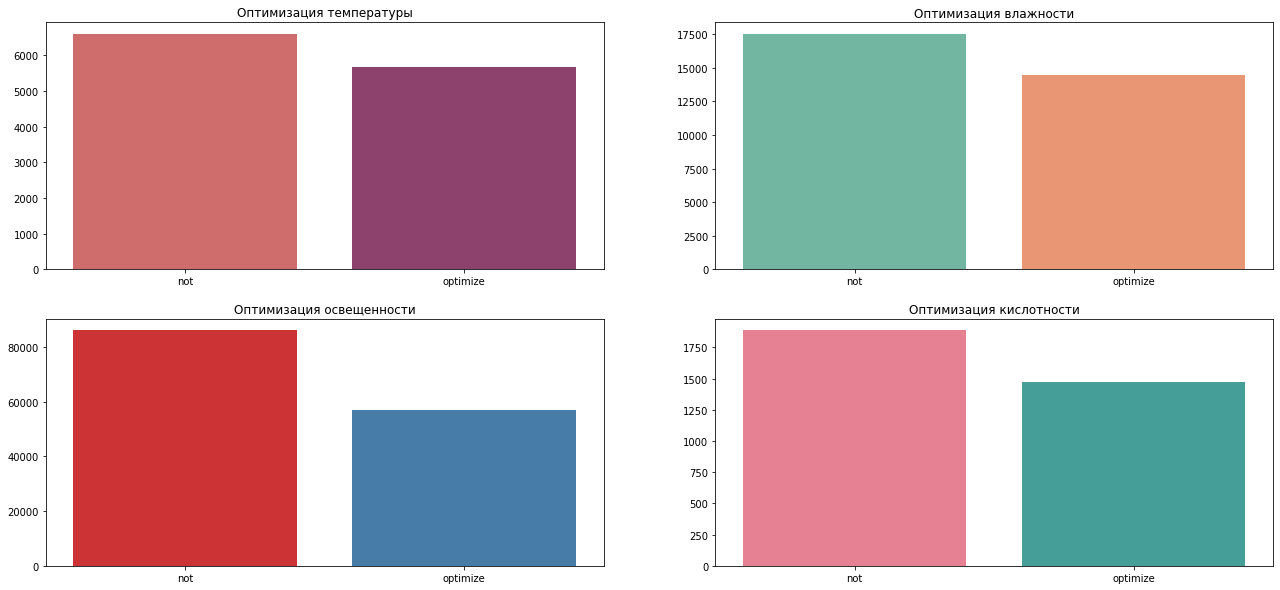

In [60]:
fig, ax = plt.subplots(2, 2, figsize=(22, 10))
sns.barplot(x=['not', 'optimize'], y=[test_y.temperature.sum(), sav_y.temperature.sum()], ax=ax[0][0], palette='flare')
ax[0][0].set(title='Оптимизация температуры')
sns.barplot(x=['not', 'optimize'], y=[test_y.humidity_mean.sum(), sav_y.humidity_mean.sum()], ax=ax[0][1], palette='Set2')
ax[0][1].set(title='Оптимизация влажности')
sns.barplot(x=['not', 'optimize'], y=[test_y.light_sum.sum(), sav_y.light_sum.sum()], ax=ax[1][0], palette='Set1')
ax[1][0].set(title='Оптимизация освещенности')
sns.barplot(x=['not', 'optimize'], y=[test_y.acid_mean.sum(), sav_y.acid_mean.sum()], ax=ax[1][1], palette='husl')
ax[1][1].set(title='Оптимизация кислотности')
fig.show()

In [63]:
print('Затраты на поддержание температуры снижены на', round(100 * (1 - sav_y.temperature.sum() / test_y.temperature.sum())))
print('Затраты на освещение снижены на', round(100 * (1 - sav_y.light_sum.sum() / test_y.light_sum.sum())))
print('Затраты на полив снижены на', round(100 * (1 - sav_y.humidity_mean.sum() / test_y.humidity_mean.sum())))
print('Затраты на поддержание уровня кислотности снижены на', round(100 * (1 - sav_y.acid_mean.sum() / test_y.acid_mean.sum())))

Затраты на поддержание температуры снижены на 14.0
Затраты на освещение снижены на 34.0
Затраты на полив снижены на 17.0
Затраты на поддержание уровня кислотности снижены на 22.0
